<a href="https://colab.research.google.com/github/AaronLingzhe/drive/blob/master/risk_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identify Disenrolled Member

The purpose of this project is to identify members who are likely to terminate their insurance plan, in order to prevent the loss of members. Note that the lost members  we want to prevent are the voluntarily disenrolled members. 
The people who are not suitable for this program (involuntarily disenroll) are not target members. Details will be discussed in the following sections. 

We first import necessary packages and load the raw data.

In [ ]:
#packages and data loading
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV#GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')
data_raw=pd.read_csv("/content/drive/My Drive/Round2-DataScience-HomeworkData.csv")

The dataset for this project is not large. For large datasets, we should use the following process to reduce  memory usage. 

In [2]:
#reduce memory usage by setting the proper data structure
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

#apply the function on the datasets
data_raw=reduce_mem_usage(data_raw)

Memory usage of dataframe is 9.99 MB
Memory usage after optimization is: 4.33 MB


# Exploratory Data Analysis(EDA)

Firstly, we have a glace on the summary of the dataset. 

In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76995 entries, 0 to 76994
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MEMBER_ID           76995 non-null  object 
 1   LOB                 76995 non-null  object 
 2   Voluntary           25206 non-null  object 
 3   churned             76995 non-null  int8   
 4   Tenure              76995 non-null  int16  
 5   hadGap.             76995 non-null  int8   
 6   Age                 76995 non-null  int8   
 7   SDOHScore           76995 non-null  float16
 8   conditionScore      76995 non-null  float16
 9   substanceScore      76995 non-null  float16
 10  physFrailtyScore    76995 non-null  float16
 11  mentalFrailtyScore  76995 non-null  float16
 12  EDCost              66365 non-null  float32
 13  EDCount             66365 non-null  float16
 14  IPCost              66365 non-null  float32
 15  IPCount             66365 non-null  float16
 16  Stat

We see that there are 17 features. Four features are categorical, and the other 13 are numeric. The target feature(responce) is 'churned'. Note that the feature 'MEMBER_ID' is just an index and does not contain useful information. Thus, We drop 'MEMBER_ID' in the following syntax.

In [4]:
#drop the useless id column
data_raw.drop(['MEMBER_ID'], axis=1, inplace=True)

## Consider Missing Value

We first show the number and the proportion of missing values for each feature.

In [5]:
#show missing values
miss_number=data_raw.isnull().sum()
miss_ratio=data_raw.isnull().sum()/len(data_raw)
miss_info=pd.DataFrame({'Number of miss':miss_number,'Proportion of miss':miss_ratio},)
miss_info=miss_info.loc[miss_info['Number of miss']>0]
miss_info=miss_info.sort_values(by='Number of miss',ascending=0)
print(miss_info[miss_info['Proportion of miss']>0])

           Number of miss  Proportion of miss
Voluntary           51789            0.672628
EDCost              10630            0.138061
EDCount             10630            0.138061
IPCost              10630            0.138061
IPCount             10630            0.138061


From the output, we see that 5 features contain missing value and the features ('EDCost', 'EDCount', 'IPCost', 'IPCount') have same number of missing values. 

### The Feature 'Voluntary'
We first consider the feature 'Voluntary' and do some analysis.

In [6]:
print('The number of missing value of "Voluntary" for disenrolled member is '+str(data_raw[data_raw['churned']==1]['Voluntary'].isna().sum()))
print('The number of non-missing value of "Voluntary" for enrolled member is '+str(data_raw[data_raw['churned']==0]['Voluntary'].notna().sum()))
print('The possible value of "Voluntary" and their counts are:')
data_raw[data_raw['churned']==1]['Voluntary'].value_counts()

The number of missing value of "Voluntary" for disenrolled member is 0
The number of non-missing value of "Voluntary" for enrolled member is 0
The possible value of "Voluntary" and their counts are:


Voluntary                         14343
Involuntary - Medicare / Other     5784
Involuntary - SNP                  5079
Name: Voluntary, dtype: int64

From the output, we can see that all the disenrolled member have information about whether or not he/she is disenrooled voluntarily. In another word, there is not actual missing value for the feature 'Voluntary'. Also, we can see that there is not any mis-type value for the feature 'Voluntary', when the member is enrolled.

We can see that there are three possible reasons when a member disenrolls. One is voluntary, the other two are involuntary. The purpose of identifying voluntary members and involuntary members are different. We need to identify the involuntary disenrolled member to transfer them to a more suitable plan in order to reduce the risk cost for this program. The purpose of finding voluntary disenrolled members is to take action in order to keep them in the program. 

The motivation of this project is to deal with the issue of "losing valuable members". Thus, we should only consider voluntarily disenrolled members as our target. If the motivation is to reduce/avoid the risk cost, then we need to set the involuntary member as a target. 


### The other four features that contain missing value
The following syntax shows some analysis about the features ('EDCost', 'EDCount', 'IPCost', 'IPCount'). 

In [7]:
data_ED_na=data_raw[data_raw['EDCost'].isna()].copy()
print('The possible value of "churned" when "EDCost" is missing: ' )
print(data_ED_na['churned'].value_counts())
print('\n')
print('The possible value of "Voluntary" when "EDCost" is missing: ' )
print(data_ED_na['Voluntary'].value_counts())
print('\n')
print('The number of missing value of "EDCount" when "EDCost" is missing: '+ str(data_ED_na['EDCount'].isna().sum()))
print('The number of missing value of "IPCost" when "EDCost" is missing: '+ str(data_ED_na['IPCost'].isna().sum()))
print('The number of missing value of "IPCount" when "EDCost" is missing: '+ str(data_ED_na['IPCount'].isna().sum()))
#they are missing simultaniously

The possible value of "churned" when "EDCost" is missing: 
1    10630
Name: churned, dtype: int64


The possible value of "Voluntary" when "EDCost" is missing: 
Voluntary                         6632
Involuntary - SNP                 2131
Involuntary - Medicare / Other    1867
Name: Voluntary, dtype: int64


The number of missing value of "EDCount" when "EDCost" is missing: 10630
The number of missing value of "IPCost" when "EDCost" is missing: 10630
The number of missing value of "IPCount" when "EDCost" is missing: 10630


From the output, we can see that the features ('EDCost', 'EDCount', 'IPCost', 'IPCount') are missing simultaneously. When their value is missing, the value of 'churned' is 1, i.e. the member has disenrolled. It can be voluntarily or involuntarily. 
Therefore, the features ('EDCost', 'EDCount', 'IPCost', 'IPCount') are not missing at random. 

If the missing condition happens before the member disenrolls, then this information is useful. Based on that, if we lose track of a member's emergency department visits or inpatient hospital visits, he/she will disenroll most likely. 

If the reason for the missing values is that the members erase the values after disenroll, then we can not predict the disenroll from whether or not the values are missing. 

Personally, I think "erase after disenroll" is more reasonable. Thus in the following analysis, I will use the medium value among disenroll members to fill the missing parts when modeling. However, we need to make a note here and communicate with the data source to confirm that. 


## Comparison between the enrolled member and disenrolled member

In [8]:
#compare
data_disenrol=data_raw[(data_raw['churned']==1) & (data_raw['Voluntary']=='Voluntary')].copy()
data_enrol=data_raw[data_raw['churned']==0].copy()
print('The number of member disenroll is '+str(data_disenrol.shape[0]))
print('The number of member enroll is '+str(data_enrol.shape[0]))

The number of member disenroll is 14343
The number of member enroll is 51789


We can see that the data is imbalanced regarding 'churned'. The number of enrolled members is about 3.5 times as the number of voluntarily disenrolled people. Thus, when we measure the performance of the classification models, the Area under the ROC curve (AUC) is a more proper evaluation than just accuracy. 

## The distribution of different features within the enrollment group and disenrollment group. 

In the following section, we analyze whether different features distribute differently under the enrollment group and disenrollment group.

### Numeric feature

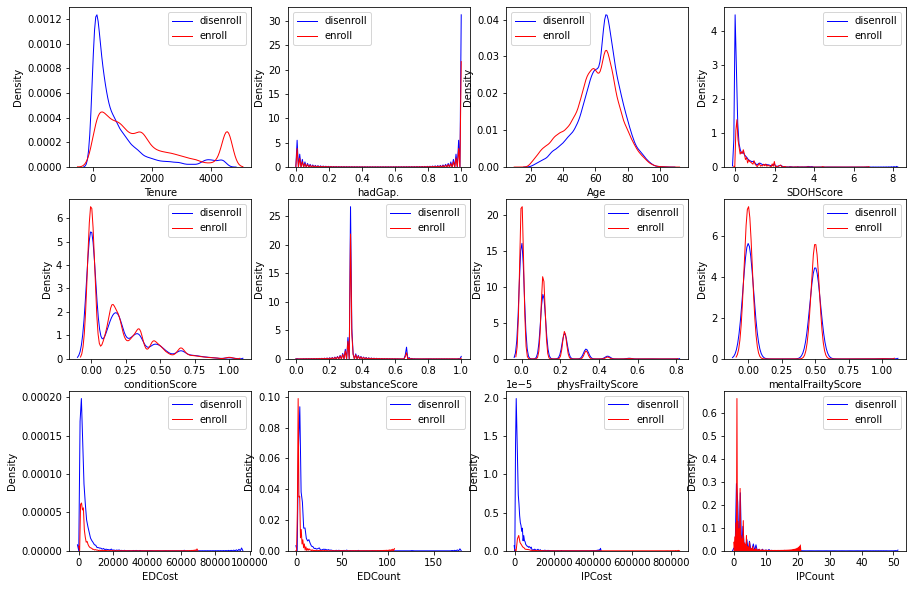

In [9]:
#density plot comparison
fig, axs = plt.subplots(3,4,figsize=(15,10))
for i,col in enumerate(data_disenrol.select_dtypes(np.number).columns[1:]):
  sns.distplot(data_disenrol[col], hist=False, color='b',label='disenroll', ax=axs[i//4,i%4],kde_kws=dict(linewidth=1))
  sns.distplot(data_enrol[col], hist=False,color='r',label='enroll', ax=axs[i//4,i%4],kde_kws=dict(linewidth=1))
  axs[i//4,i%4].set_ylabel('Density')
plt.show()

From the density plots, we see that the distribution of 'Tenure', 'EDCost', 'SDOHScore', 'EDCost', and 'IPCost' look different under enrolled and disenrolled member. Specifically, the distribution of Number of days the member with the company ('Tenure') is obviously different between the two groups. For the enrollment group, there is a major density in around 4500 days. The reason might be the promotion when the plan first release. After that, the enrollment number grows gradually until recently. In terms of the disenrollment group, the majority is close to zero. It means that most disenrolled people are the ones that newly facing the plan. If it is recent data, the reason might be the pandemic. People are cutting costs on their new plan.

Note that such cases might be a general situation. Therefore, when we take actions to prevent losing members. If the action is useful, it might be worth considering attracting the people that disenrolled from other companies' plan.


### Category feature

There are only two category features we care about: 'LOB' and 'State'. We can plot the histogram for these two features. 

In [10]:
# Number of unique classes in each object column
data_raw.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

LOB          8
Voluntary    3
State        4
dtype: int64

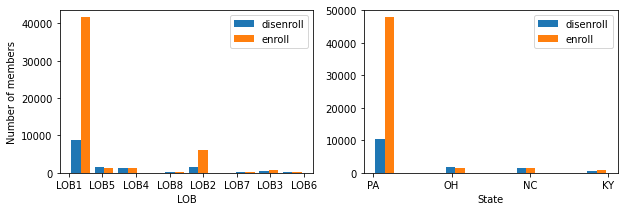

In [11]:
fig, axs = plt.subplots(1,2,figsize=(10,3))
for i,col in enumerate(['LOB','State']):
  axs[i].hist([data_disenrol[col],data_enrol[col]],label=['disenroll', 'enroll'])
  axs[i].legend()
  axs[i].set_xlabel(col)
axs[0].set_ylabel('Number of members')
plt.show()

From the plots, we see that the Line 1 and Line 2 have major population. In terms of the states, PA has major population. If there is not a clear reason for that yet, there might be some information to dig into. If more advertisement is put in PA, then it might be the reason.

# Classification Models

We use logistic regression, xgboost, lightgbm and stacking them to form the final model. As mentioned before, we only consider voluntarily disenrolled members. Before building and training models, we keep 20% of the raw data as the testing data. The missing values are filled by the median from the training data. 


In [12]:
data_raw=pd.read_csv("/content/drive/My Drive/Round2-DataScience-HomeworkData.csv")
data_raw.drop(['MEMBER_ID'], axis=1, inplace=True)

#involuntary member is not target in this project, another project is needed to identify these people.
data_raw_adj=data_raw[(data_raw['Voluntary'].isna()) | (data_raw['Voluntary']=='Voluntary')].copy()

#split into training set and testing set
# split data into train and test sets
test_size = 0.2
data_train, data_test = train_test_split(data_raw_adj, test_size=test_size)

In [13]:
#fill missing values
for col in ['EDCost','EDCount','IPCost','IPCount']:
    data_train[col] = data_train[col].fillna(data_train[data_train['churned']==1][col].median())
    data_test[col] = data_test[col].fillna(data_train[data_train['churned']==1][col].median())

In [14]:
#In this dataset, all the binary feature are in 0/1, it's good. Otherwise, we should transform binary to 0/1 with the following function.
def labelencoder_dataframe(df):
    for col in df.columns:
        if len(set(df[col]))==2:
            lbl = LabelEncoder()
            lbl.fit(list(df[col].values.astype('str')))
            df[col] = lbl.transform(list(df[col].values.astype('str')))
    return df

#separate feature and responds for training data
x_train=data_train.copy()
x_train.drop(['churned','Voluntary'], axis=1, inplace=True)
y_train=data_train['churned']
x_train=labelencoder_dataframe(x_train)
#Get dummies for catigory variables.
x_train=pd.get_dummies(x_train)

#separate feature and responds for testing data
x_test=data_test.copy()
x_test.drop(['churned','Voluntary'], axis=1, inplace=True)
y_test=data_test['churned']
x_test=labelencoder_dataframe(x_test)
#Get dummies for catigory variables.
x_test=pd.get_dummies(x_test)

## Logistic Regression

In [15]:
#logistic regression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='l2')

## Xgboost

In [16]:
#xgboost
import xgboost as xgb
print('####################################################\n{}\start_time'.format(datetime.datetime.now().strftime('%H:%M')))
params={
    'n_estimators':[100,300],#100,300
    'max_depth':[3],#,5,10
    'learning_rate':[0.01],#0.05,0.1,0.01
    'subsample':[0.5],#0.4,0.5,0.6,0.7,0.9
    'tree_method':['gpu_hist']  # THE MAGICAL PARAMETER, use gpu
        }

xgb_temp = xgb.XGBClassifier()
model_xgb_tuned = GridSearchCV(xgb_temp, params,scoring='roc_auc',cv=5)
model_xgb_tuned.fit(x_train,y_train)
model_xgb = xgb.XGBClassifier(**model_xgb_tuned.best_params_)

print(model_xgb)
print('{}\tEnd_time\n####################################################'.format(datetime.datetime.now().strftime('%H:%M')))

####################################################
02:44\start_time
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, tree_method='gpu_hist', verbosity=1)
02:44	End_time
####################################################


## LightGBM

In [17]:
#lightGBM
from sklearn.model_selection import KFold
import lightgbm as lgb
import datetime
print('####################################################\n{}\start_time'.format(datetime.datetime.now().strftime('%H:%M')))
params = {'objective': ['binary'],
          'boosting_type': ["gbdt"],
          'metric': ['auc'],
          #'verbosity': [-1],
          'n_estimators':[100,300],#100,300
          'feature_fraction': [0.4],#0.3,0.7,0.9,0.5,0.6
          'bagging_fraction': [0.9],#0.5,0.7,1,0.8
          'bagging_freq':[1],
          'max_depth': [5],
          'learning_rate': [0.1],#0.1,0.05
          #'device_type':['gpu']
         }

lgb_temp = lgb.LGBMClassifier()
model_lgb_tuned = GridSearchCV(lgb_temp, params,scoring='roc_auc',n_jobs=-1,cv=5)
model_lgb_tuned.fit(x_train,y_train)
model_lgb = lgb.LGBMClassifier(**model_lgb_tuned.best_params_)

print(model_lgb_tuned.best_params_)
print('{}\tEnd_time\n####################################################'.format(datetime.datetime.now().strftime('%H:%M')))

####################################################
02:44\start_time
{'bagging_fraction': 0.9, 'bagging_freq': 1, 'boosting_type': 'gbdt', 'feature_fraction': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'auc', 'n_estimators': 300, 'objective': 'binary'}
02:44	End_time
####################################################


## Use Cross Validation to Compare the Performance and Stacking the Models

We have just tuning the hyper-parameters for Xgboost and LightGBM. In this section, we use cross validation to compare the performance of different models and stacking the efficient ones. We use area under the ROC curve (AUC) as the evaluation criterion. 

In [18]:
%%time
#cross validation to Compare the Performance and Stacking the Models
from sklearn.model_selection import KFold,cross_val_score
from mlxtend.classifier import StackingClassifier

#Validation function
n_folds = 5

models = {
    'Logistic':model_lr,
    'Lightgbm':model_lgb,
    'XGBoost':model_xgb,
    #'Random forest':model_rf  #random forest is time consuming
    }

for model_ind, model_fn in models.items():
    print('Fitting:\t{}'.format(model_ind))
    #model_fn.fit(x_train, y_train)
    
    #cross validation
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    auc= cross_val_score(model_fn, x_train, y_train, scoring='roc_auc', cv = kf)    
    
    print('Done! Error:\t{}\n'.format(auc.mean()))

#combine the model together(stacking)
lr = LogisticRegression()
averaged_models=StackingClassifier(classifiers=[model_lgb, model_xgb], 
                                   use_probas=True,average_probas=True,meta_classifier=lr)

kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
auc= cross_val_score(averaged_models, x_train, y_train, scoring='roc_auc', cv = kf)
score =auc.mean()
print(" Averaged base models score: \t{}\n".format(score))


Fitting:	Logistic
Done! Error:	0.8153528941694435

Fitting:	Lightgbm
Done! Error:	0.9777186272858966

Fitting:	XGBoost
Done! Error:	0.9436455505051619

 Averaged base models score: 	0.9706726373757417

CPU times: user 25.6 s, sys: 5.62 s, total: 31.2 s
Wall time: 26.9 s


Note that the result will be slightly outperform than real because we use the median value from disenroll members to fill the missing part for features ('EDCost', 'EDCount', 'IPCost', 'IPCount'). It bring extra information when we use the cross validation. 

# Evaluation and Further Discussion

In this section, we use the reserved testing dataset to evaluate our final model. 


In [19]:
averaged_models.fit(x_train, y_train)
y_test_pred_prob=averaged_models.predict_proba(x_test)[:,1]
print('The value of AUC for the testing sample is '+str(roc_auc_score(y_test,y_test_pred_prob)))

The value of AUC for the testing sample is 0.97228550237786


We can also calculate the precision(the propotion of actual position among all claimed positive) and recall(the propotion of claimed positive among all actual positive) of the classification with given threshold.

In [20]:
threshold=0.5
y_pred=y_test_pred_prob>threshold
print('When choosing the threshold as '+ str(threshold)+ ',')
print('the precision is '+str(precision_score(y_test,y_pred)))
print('the recall is '+ str(recall_score(y_test,y_pred)))

When choosing the threshold as 0.5,
the precision is 0.8850350740452065
the recall is 0.780949105914718


## Feature Importance

We can also consider the importance of different features when we use them in the model. We calculate it under the lightGBM model and use gain as the criterion to measure the importance.


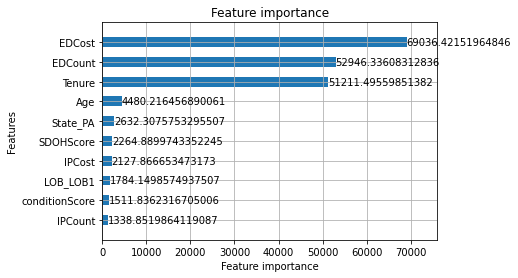

In [21]:
#feature importance
lgb_reg = model_lgb.fit(x_train,y_train)
ax = lgb.plot_importance(lgb_reg,  max_num_features=10, height = 0.5,importance_type='gain')
plt.show()

From the output of feature importance, we see that the feature 'EDCost', 'EDCount' and 'Tenure' contain most information to identify disenrolled member. The reseult is consistent to the situation that the distribution of these feature are different between enrollment group and disenrollment group. 

## Further research

If there is a dramatic increase in the cost for this plan, then we need to identify the involuntary disenrolled members and analyze their characteristics.